In [6]:
import numpy as np
import sklearn.preprocessing as prep
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

def xavier_init( fan_in, fan_out, constant = 1 ):
    low  = -constant * np.sqrt( 6.0 / ( fan_in + fan_out ) )
    high =  constant * np.sqrt( 6.0 / ( fan_in + fan_out ) )
    return tf.random_uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.float32 )

class AdditiveGaussianNoiseAutoencoder(object):
    def __init__(self, n_input, n_hidden, transfer_function=tf.nn.softplus, optimizer = tf.train.AdamOptimizer(), scale=0.1 ):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.transfer = transfer_function
        self.scale = tf.placeholder( tf.float32 )
        self.training_scale = scale
        network_weights = self._initialize_weights()
        self.weights = network_weights

        self.x = tf.placeholder( tf.float32, [None, self.n_input] )
        self.hidden = self.transfer( tf.add( tf.matmul(self.x + scale * tf.random_normal(( n_input, ) ), self.weights['w1'] ), self.weights['b1'] ))
        self.reconstruction = tf.add( tf.matmul( self.hidden, self.weights['w2'] ), self.weights['b2'] )
        self.cost = 0.5 * tf.reduce_sum( tf.pow( tf.subtract( self.reconstruction, self.x ), 2 ) )
        self.optimizer = optimizer.minimize( self.cost )
        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run( init )
        print ("begin to run session...")
    def _initialize_weights(self):
        all_weights = dict()
        all_weights['w1'] = tf.Variable( xavier_init( self.n_input, self.n_hidden ) )
        all_weights['b1'] = tf.Variable( tf.zeros( [self.n_hidden], dtype = tf.float32 ) )
        all_weights['w2'] = tf.Variable( tf.zeros([self.n_hidden, self.n_input], dtype = tf.float32) )
        all_weights['b2'] = tf.Variable( tf.zeros( [self.n_input], dtype = tf.float32 ) )
        return all_weights

    def partial_fit(self, X):
        cost, opt = self.sess.run( (self.cost, self.optimizer), 
                                feed_dict = { self.x : X, self.scale : self.training_scale } )
        return cost

    def calc_total_cost( self, X ):
        return self.sess.run( self.cost, feed_dict = { self.x : X, self.scale : self.training_scale } )

    def transform( self, X ):
        return self.sess.run( self.hidden, feed_dict = { self.x : X, self.scale : self.training_scale } )

    def generate( self, hidden = None ):
        if hidden == None:
            hidden = np.random.normal( size = self.weights['b1'] )
        return self.sess.run( self.reconstruction, feed_dict = { self.hidden : hidden } )

    def reconstruction( self, X ):
        return self.sess.run( self.reconstruction, feed_dict = { self.x : X, self.scale : self.training_scale } )

    def getWeights( self ):
        return self.sess.run( self.weights['w1'] )

    def getBiases( self ):
        return self.sess.run( self.weights['b1'] )


mnist = input_data.read_data_sets( 'D:/python_code/MNIST_data', one_hot = True )

def standard_scale( X_train, X_test ):
    preprocessor = prep.StandardScaler().fit( X_train )
    X_train = preprocessor.transform( X_train )
    X_test  = preprocessor.transform( X_test )
    return X_train, X_test

def get_random_block_from_data( data, batch_size ):
    start_index = np.random.randint( 0, len(data) - batch_size )
    return data[ start_index : (start_index+batch_size)  ]

X_train, X_test  =standard_scale( mnist.train.images, mnist.test.images )

n_samples = int( mnist.train.num_examples )
training_epochs = 20
batch_size = 128
display_step = 1

autoencoder = AdditiveGaussianNoiseAutoencoder( n_input = 784,
                                                n_hidden = 200, 
                                                transfer_function = tf.nn.softplus,
                                                optimizer = tf.train.AdamOptimizer( learning_rate = 0.0001 ),
                                                scale = 0.01 )

for epoch in range( training_epochs ):
    avg_cost = 0
    total_batch = int( n_samples / batch_size )
    for i in range( total_batch ):
        batch_xs = get_random_block_from_data( X_train, batch_size )

        cost = autoencoder.partial_fit( batch_xs )
        avg_cost = cost / n_samples * batch_size

    if epoch % display_step == 0:
        print( "epoch : %04d, cost = %.9f" % ( epoch+1, avg_cost ) )

print( "Total cost : ",  str(autoencoder.calc_total_cost(X_test) ))

Extracting D:/python_code/MNIST_data\train-images-idx3-ubyte.gz
Extracting D:/python_code/MNIST_data\train-labels-idx1-ubyte.gz
Extracting D:/python_code/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting D:/python_code/MNIST_data\t10k-labels-idx1-ubyte.gz
begin to run session...
epoch : 0001, cost = 65.297350000
epoch : 0002, cost = 49.289054545
epoch : 0003, cost = 22.602404545
epoch : 0004, cost = 22.731361364
epoch : 0005, cost = 57.419490909
epoch : 0006, cost = 18.303593182
epoch : 0007, cost = 17.665515909
epoch : 0008, cost = 30.850431818
epoch : 0009, cost = 64.724840909
epoch : 0010, cost = 17.285590909
epoch : 0011, cost = 29.362490909
epoch : 0012, cost = 22.763936364
epoch : 0013, cost = 19.814765909
epoch : 0014, cost = 21.702479545
epoch : 0015, cost = 14.131407955
epoch : 0016, cost = 19.846636364
epoch : 0017, cost = 12.640061364
epoch : 0018, cost = 10.889230682
epoch : 0019, cost = 15.212372727
epoch : 0020, cost = 102.105627273
Total cost :  801789.0


In [8]:
#加多层网络进行改进
import numpy as np
import sklearn.preprocessing as prep
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

def xavier_init( fan_in, fan_out, constant = 1 ):
    low  = -constant * np.sqrt( 6.0 / ( fan_in + fan_out ) )
    high =  constant * np.sqrt( 6.0 / ( fan_in + fan_out ) )
    return tf.random_uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.float32 )

class AdditiveGaussianNoiseAutoencoder(object):
    def __init__(self, n_input, n_hidden, transfer_function=tf.nn.softplus, optimizer = tf.train.AdamOptimizer(), scale=0.1 ):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.transfer = transfer_function
        self.scale = tf.placeholder( tf.float32 )
        self.training_scale = scale
        network_weights = self._initialize_weights()
        self.weights = network_weights

        self.x = tf.placeholder( tf.float32, [None, self.n_input] )
        self.hidden1 = self.transfer( tf.add( tf.matmul(self.x + scale * tf.random_normal(( n_input, ) ), self.weights['w11'] ), self.weights['b11'] ))
        self.hidden2 = self.transfer(tf.add(tf.matmul(self.hidden1,self.weights['w12']),self.weights['b12']))
        self.reconstruction1 = self.transfer(tf.add( tf.matmul( self.hidden2, self.weights['w21'] ), self.weights['b21'] ))
        self.reconstruction2 = self.transfer(tf.add(tf.matmul(self.reconstruction1,self.weights['w22']),self.weights['b22']))
        
        self.cost = 0.5 * tf.reduce_sum( tf.pow( tf.subtract( self.reconstruction2, self.x ), 2 ) )
        self.optimizer = optimizer.minimize( self.cost )
        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run( init )
        print ("begin to run session...")
    def _initialize_weights(self):
        all_weights = dict()
        all_weights['w11'] = tf.Variable( xavier_init( self.n_input, self.n_hidden[0] ) )
        all_weights['b11'] = tf.Variable( tf.zeros( [self.n_hidden[0]], dtype = tf.float32 ) )
        
        all_weights['w12'] = tf.Variable( tf.zeros( [self.n_hidden[0],self.n_hidden[1]], dtype = tf.float32 ) )
        all_weights['b12'] = tf.Variable( tf.zeros( [self.n_hidden[1]], dtype = tf.float32 ) )
        
        all_weights['w21'] = tf.Variable( tf.zeros([self.n_hidden[1], self.n_hidden[0]], dtype = tf.float32) )
        all_weights['b21'] = tf.Variable( tf.zeros( [self.n_hidden[0]], dtype = tf.float32 ) )
        
        all_weights['w22'] = tf.Variable( tf.zeros([self.n_hidden[0], self.n_input], dtype = tf.float32) )
        all_weights['b22'] = tf.Variable( tf.zeros( [self.n_input], dtype = tf.float32 ) )
        return all_weights

    def partial_fit(self, X):
        cost, opt = self.sess.run( (self.cost, self.optimizer), 
                                feed_dict = { self.x : X, self.scale : self.training_scale } )
        return cost

    def calc_total_cost( self, X ):
        return self.sess.run( self.cost, feed_dict = { self.x : X, self.scale : self.training_scale } )

    def transform( self, X ):
        return self.sess.run( self.hidden2, feed_dict = { self.x : X, self.scale : self.training_scale } )

    def generate( self, reconstruction1 = None ):
        if reconstruction1 == None:
            reconstruction1 = np.random.normal( size = self.weights['b21'] )
        return self.sess.run( self.reconstruction2, feed_dict = { self.reconstruction1 : reconstruction1 } )

    def reconstruction( self, X ):
        return self.sess.run( self.reconstruction2, feed_dict = { self.x : X, self.scale : self.training_scale } )

    def getWeights( self ):
        return self.sess.run( self.weights['w11'] )

    def getBiases( self ):
        return self.sess.run( self.weights['b11'] )


mnist = input_data.read_data_sets( 'D:/python_code/MNIST_data', one_hot = True )

def standard_scale( X_train, X_test ):
    preprocessor = prep.StandardScaler().fit( X_train )
    X_train = preprocessor.transform( X_train )
    X_test  = preprocessor.transform( X_test )
    return X_train, X_test

def get_random_block_from_data( data, batch_size ):
    start_index = np.random.randint( 0, len(data) - batch_size )
    return data[ start_index : (start_index+batch_size)  ]

X_train, X_test  =standard_scale( mnist.train.images, mnist.test.images )

n_samples = int( mnist.train.num_examples )
training_epochs = 20
batch_size = 128
display_step = 1

autoencoder = AdditiveGaussianNoiseAutoencoder( n_input = 784,
                                                n_hidden = [256,128], 
                                                transfer_function = tf.nn.softplus,
                                                optimizer = tf.train.AdamOptimizer( learning_rate = 0.0001 ),
                                                scale = 0.01 )

for epoch in range( training_epochs ):
    avg_cost = 0
    total_batch = int( n_samples / batch_size )
    for i in range( total_batch ):
        batch_xs = get_random_block_from_data( X_train, batch_size )

        cost = autoencoder.partial_fit( batch_xs )
        avg_cost = cost / n_samples * batch_size

    if epoch % display_step == 0:
        print( "epoch : %04d, cost = %.9f" % ( epoch+1, avg_cost ) )

print( "Total cost : ",  str(autoencoder.calc_total_cost(X_test) ))

Extracting D:/python_code/MNIST_data\train-images-idx3-ubyte.gz
Extracting D:/python_code/MNIST_data\train-labels-idx1-ubyte.gz
Extracting D:/python_code/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting D:/python_code/MNIST_data\t10k-labels-idx1-ubyte.gz
begin to run session...
epoch : 0001, cost = 129.596200000
epoch : 0002, cost = 89.099872727
epoch : 0003, cost = 93.689627273
epoch : 0004, cost = 68.865418182
epoch : 0005, cost = 110.781609091
epoch : 0006, cost = 89.821363636
epoch : 0007, cost = 109.453290909
epoch : 0008, cost = 85.723727273
epoch : 0009, cost = 101.734600000
epoch : 0010, cost = 97.185481818
epoch : 0011, cost = 69.346686364
epoch : 0012, cost = 103.672000000
epoch : 0013, cost = 68.291113636
epoch : 0014, cost = 95.826745455
epoch : 0015, cost = 91.833236364
epoch : 0016, cost = 137.382481818
epoch : 0017, cost = 94.135263636
epoch : 0018, cost = 113.584218182
epoch : 0019, cost = 100.768636364
epoch : 0020, cost = 76.616918182
Total cost :  3.45709e+06


### 另一自编码器代码

Extracting D:/python_code/MNIST_data\train-images-idx3-ubyte.gz
Extracting D:/python_code/MNIST_data\train-labels-idx1-ubyte.gz
Extracting D:/python_code/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting D:/python_code/MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch: 0001 cost= 0.199292555
Epoch: 0002 cost= 0.167228431
Epoch: 0003 cost= 0.152243316
Epoch: 0004 cost= 0.143325940
Epoch: 0005 cost= 0.132756814
Epoch: 0006 cost= 0.128655270
Epoch: 0007 cost= 0.126502544
Epoch: 0008 cost= 0.121090338
Epoch: 0009 cost= 0.117880978
Epoch: 0010 cost= 0.116179012
Epoch: 0011 cost= 0.116325103
Epoch: 0012 cost= 0.114900336
Epoch: 0013 cost= 0.111024372
Epoch: 0014 cost= 0.108595937
Epoch: 0015 cost= 0.107695632
Epoch: 0016 cost= 0.104813166
Epoch: 0017 cost= 0.102613904
Epoch: 0018 cost= 0.097348489
Epoch: 0019 cost= 0.099608921
Epoch: 0020 cost= 0.099133216
Optimization Finished!


D:\anaconda1\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


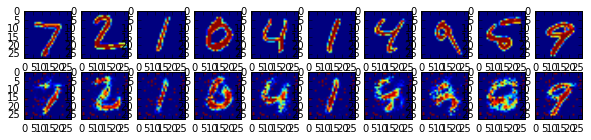

In [9]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("D:/python_code/MNIST_data", one_hot=True)

# Parameters
learning_rate = 0.01
training_epochs = 20
batch_size = 256
display_step = 1
examples_to_show = 10

# Network Parameters
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 128 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    total_batch = int(mnist.train.num_examples/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")

    # Applying encode and decode over test set
    encode_decode = sess.run(
        y_pred, feed_dict={X: mnist.test.images[:examples_to_show]})
    # Compare original images with their reconstructions
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    f.show()
    plt.draw()
#     plt.waitforbuttonpress()